# Sentiment Analysis of FOMC Statements

Analyse statement by Loughran and McDonald dictionary

In [1]:
%config InlineBackend.figure_format='retina'
import logging
from ekorpkit import eKonf

logging.basicConfig(level=logging.INFO)
print("version:", eKonf.__version__)
print("is notebook?", eKonf.is_notebook())
print("is colab?", eKonf.is_colab())
print("evironment varialbles:")
eKonf.print(eKonf.env().dict())

INFO:ekorpkit.base:IPython version: (6, 9, 0), client: jupyter_client
INFO:ekorpkit.base:Google Colab not detected.


version: 0.1.33+24.gd2d9e99.dirty
is notebook? True
is colab? False
evironment varialbles:
{'EKORPKIT_CONFIG_DIR': '/workspace/projects/ekorpkit-book/config',
 'EKORPKIT_DATA_DIR': None,
 'EKORPKIT_PROJECT': 'ekorpkit-book',
 'EKORPKIT_WORKSPACE_ROOT': '/workspace',
 'NUM_WORKERS': 230}


In [2]:
start_year = 2000
data_dir = "../data/fomc"
eKonf.env().FRED_API_KEY

pydantic.types.SecretStr

## Load FOMC Corpus

In [3]:
fomc_sents = eKonf.load_data("fomc_sents.parquet", data_dir)
fomc_sents.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sents.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_sents.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_sents.parquet


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id
653463,2854,It will not have the word “somewhat” on line 3.,train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,10,287,2
653464,2854,Chair Yellen Yes Vice Chairman Dudley ...,train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,31,287,4
653465,2854,And let me confirm that the next meeting will ...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,19,288,3
653466,2854,I believe box lunches are now available for pe...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,33,288,4
653467,2854,"I will do my best, and I will consider at the ...",train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,18,288,5


## Predict sentiments with the LM sentiment analyser

In [4]:
model_cfg = eKonf.compose('model/sentiment=lm')
model_cfg.num_workers = 10
lmsa = eKonf.instantiate(model_cfg)

INFO:ekorpkit.preprocessors.tokenizer:instantiating ekorpkit.preprocessors.stopwords.Stopwords...
INFO:ekorpkit.base:Calling load_candidates
INFO:ekorpkit.io.file:Processing [1] files from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading data from /workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet
INFO:ekorpkit.models.ngram.ngram:loaded 58142 candidates


In [5]:
article = fomc_sents.text[10]
lmsa.predict_sentence(article)

{'num_tokens': 156,
 'polarity': -0.9999990000010001,
 'polarity_label': 'negative',
 'uncertainty': 1e-06}

In [6]:
model_cfg = eKonf.compose('model/sentiment=lm')

cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.model = model_cfg
cfg.output_dir = "../data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'
cfg.num_workers = 100
cfg.verbose = True
fomc_data = eKonf.pipe(fomc_sents, cfg)
fomc_data.head()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function predict at 0x7fddfe1a4820>)
INFO:ekorpkit.base:instantiating ekorpkit.models.sentiment.base.SentimentAnalyser...
INFO:ekorpkit.preprocessors.tokenizer:instantiating ekorpkit.preprocessors.stopwords.Stopwords...
INFO:ekorpkit.base:Calling load_candidates
INFO:ekorpkit.io.file:Processing [1] files from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading data from /workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet
INFO:ekorpkit.models.ngram.ngram:loaded 58142 candidates
INFO:ekorpkit.models.sentiment.base:Predicting sentiments of the column [text] using predict_sentence
INFO:ekorpkit.base:Using batcher with minibatch size: 1000
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 1000  procs: 100  input_split: False  merge_output

,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,...,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id,num_tokens,polarity,polarity_label,uncertainty
0,0,The Secretary reported that advices of the ele...,train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,47,29,0,52,0.000000,neutral,0.000001
1,0,"By unanimous vote, the Committee elected the f...",train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,73,35,0,78,-1.000000,negative,0.000001
2,0,"By unanimous vote, William J. McDonough, Marga...",train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,74,37,0,83,1.000000,positive,0.000001
3,0,"On January 15, 1993, the continuing rules, reg...",train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,59,39,0,68,-0.333333,negative,0.014707
4,0,Members were asked to indicate if they wished ...,train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,25,39,1,26,-0.999999,negative,0.000001


In [3]:
cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.output_dir = "../data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'

fomc_data = eKonf.load_data(cfg.output_file, cfg.output_dir)
fomc_data.head()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sentiments-lm.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/predict/fomc_sentiments-lm.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/predict/fomc_sentiments-lm.parquet


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,...,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id,num_tokens,polarity,polarity_label,uncertainty
0,0,The Secretary reported that advices of the ele...,train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,47,29,0,52,0.000000,neutral,0.000001
1,0,"By unanimous vote, the Committee elected the f...",train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,73,35,0,78,-1.000000,negative,0.000001
2,0,"By unanimous vote, William J. McDonough, Marga...",train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,74,37,0,83,1.000000,positive,0.000001
3,0,"On January 15, 1993, the continuing rules, reg...",train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,59,39,0,68,-0.333333,negative,0.014707
4,0,Members were asked to indicate if they wished ...,train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,...,1993-02-18,0.0,3.0,25,39,1,26,-0.999999,negative,0.000001


In [4]:
model_cfg = eKonf.compose('model/sentiment')
lbsa = eKonf.instantiate(model_cfg)

In [63]:
fomc_sentiments = lbsa.aggregate_scores(fomc_data, groupby=['content_type', 'recent_meeting'])
fomc_sentiments.content_type = fomc_sentiments.content_type.str.replace('fomc_', '')
eKonf.save_data(fomc_sentiments, 'fomc_sentiments.parquet', data_dir)
fomc_sentiments

INFO:ekorpkit.io.file:Saving dataframe to ../data/fomc/fomc_sentiments.parquet


,content_type,recent_meeting,polarity_mean,polarity_diffusion,positive,negative,num_tokens_sum,num_tokens_mean,num_tokens_median,num_examples,polarity_mean_label,polarity_diffusion_label
0,beigebook,2020-12-16,-0.068247,-0.071053,3972,5229,397855,22.489119,21.0,17691,neutral,neutral
1,beigebook,2021-01-27,-0.032683,-0.037384,3887,4518,381300,22.590201,21.0,16879,neutral,neutral
2,beigebook,2021-03-17,-0.030535,-0.035085,3568,4100,340121,22.430983,21.0,15163,neutral,neutral
3,beigebook,2021-04-28,-0.039873,-0.044760,3837,4561,357745,22.117156,21.0,16175,neutral,neutral
4,beigebook,2021-06-16,0.011743,0.012195,191,182,15803,21.413279,21.0,738,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
1060,testimony,2021-03-17,-0.244167,-0.275000,6,28,2478,30.975000,28.5,80,negative,negative
1061,testimony,2021-04-28,-0.171642,-0.164179,15,26,2590,38.656716,29.0,67,negative,negative
1062,testimony,2021-06-16,0.235955,0.247191,34,12,2522,28.337079,26.0,89,positive,positive
1063,testimony,2021-09-22,0.031746,0.000000,9,9,1026,24.428571,22.0,42,neutral,neutral


In [21]:
# fomc_sentiments = eKonf.to_datetime(fomc_sentiments, _columns=['recent_meeting'])
fomc_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   content_type              1065 non-null   object        
 1   recent_meeting            1065 non-null   datetime64[ns]
 2   polarity_mean             1059 non-null   float64       
 3   polarity_diffusion        1059 non-null   float64       
 4   positive                  1065 non-null   int64         
 5   negative                  1065 non-null   int64         
 6   num_tokens_sum            1065 non-null   int64         
 7   num_tokens_mean           1065 non-null   float64       
 8   num_tokens_median         1065 non-null   float64       
 9   num_examples              1065 non-null   int64         
 10  polarity_mean_label       1059 non-null   object        
 11  polarity_diffusion_label  1059 non-null   object        
dtypes: datetime64[ns](1)

In [37]:
cfg = eKonf.compose('pipeline/pivot')
cfg.index = 'recent_meeting'
cfg.columns = 'content_type'
cfg.values = ['polarity_mean', 'polarity_diffusion', 'num_examples', 'num_tokens_sum', 'num_tokens_mean']
data = eKonf.pipe(fomc_sentiments, cfg)
data = data.set_index('recent_meeting')
data.tail()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function pivot at 0x7f4f9d579af0>)


,polarity_mean_beigebook,polarity_mean_meeting_script,polarity_mean_minutes,polarity_mean_press_conf,polarity_mean_speech,polarity_mean_statement,polarity_mean_testimony,polarity_diffusion_beigebook,polarity_diffusion_meeting_script,polarity_diffusion_minutes,...,num_tokens_sum_speech,num_tokens_sum_statement,num_tokens_sum_testimony,num_tokens_mean_beigebook,num_tokens_mean_meeting_script,num_tokens_mean_minutes,num_tokens_mean_press_conf,num_tokens_mean_speech,num_tokens_mean_statement,num_tokens_mean_testimony
recent_meeting,,,,,,,,,,,,,,,,,,,,,
2021-06-16,0.011743,NaN,0.041638,-0.017544,-0.031786,0.435897,0.235955,0.012195,NaN,0.031142,...,6894.0,384.0,2522.0,21.413279,NaN,30.615917,27.100000,29.088608,29.538462,28.337079
2021-07-28,-0.120547,NaN,-0.043969,0.021318,-0.042941,0.461538,NaN,-0.134921,NaN,-0.069079,...,13170.0,399.0,NaN,20.980159,NaN,32.888158,27.261628,29.072848,30.692308,NaN
2021-09-22,-0.074328,NaN,-0.079199,-0.087292,-0.133837,0.476190,0.031746,-0.075712,NaN,-0.112403,...,31138.0,419.0,1026.0,22.957808,NaN,31.348837,25.809384,29.431002,29.928571,24.428571
2021-11-03,-0.046022,NaN,-0.064255,-0.089881,-0.030345,0.215686,-0.120000,-0.048109,NaN,-0.080851,...,26096.0,538.0,556.0,22.539497,NaN,31.880851,27.720238,31.980392,31.647059,27.800000
2021-12-15,NaN,NaN,-0.043929,-0.075441,-0.356613,0.166667,NaN,NaN,NaN,-0.064286,...,3694.0,489.0,NaN,NaN,NaN,30.521429,37.587413,29.317460,27.166667,NaN


## Plot the sentiment scores

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


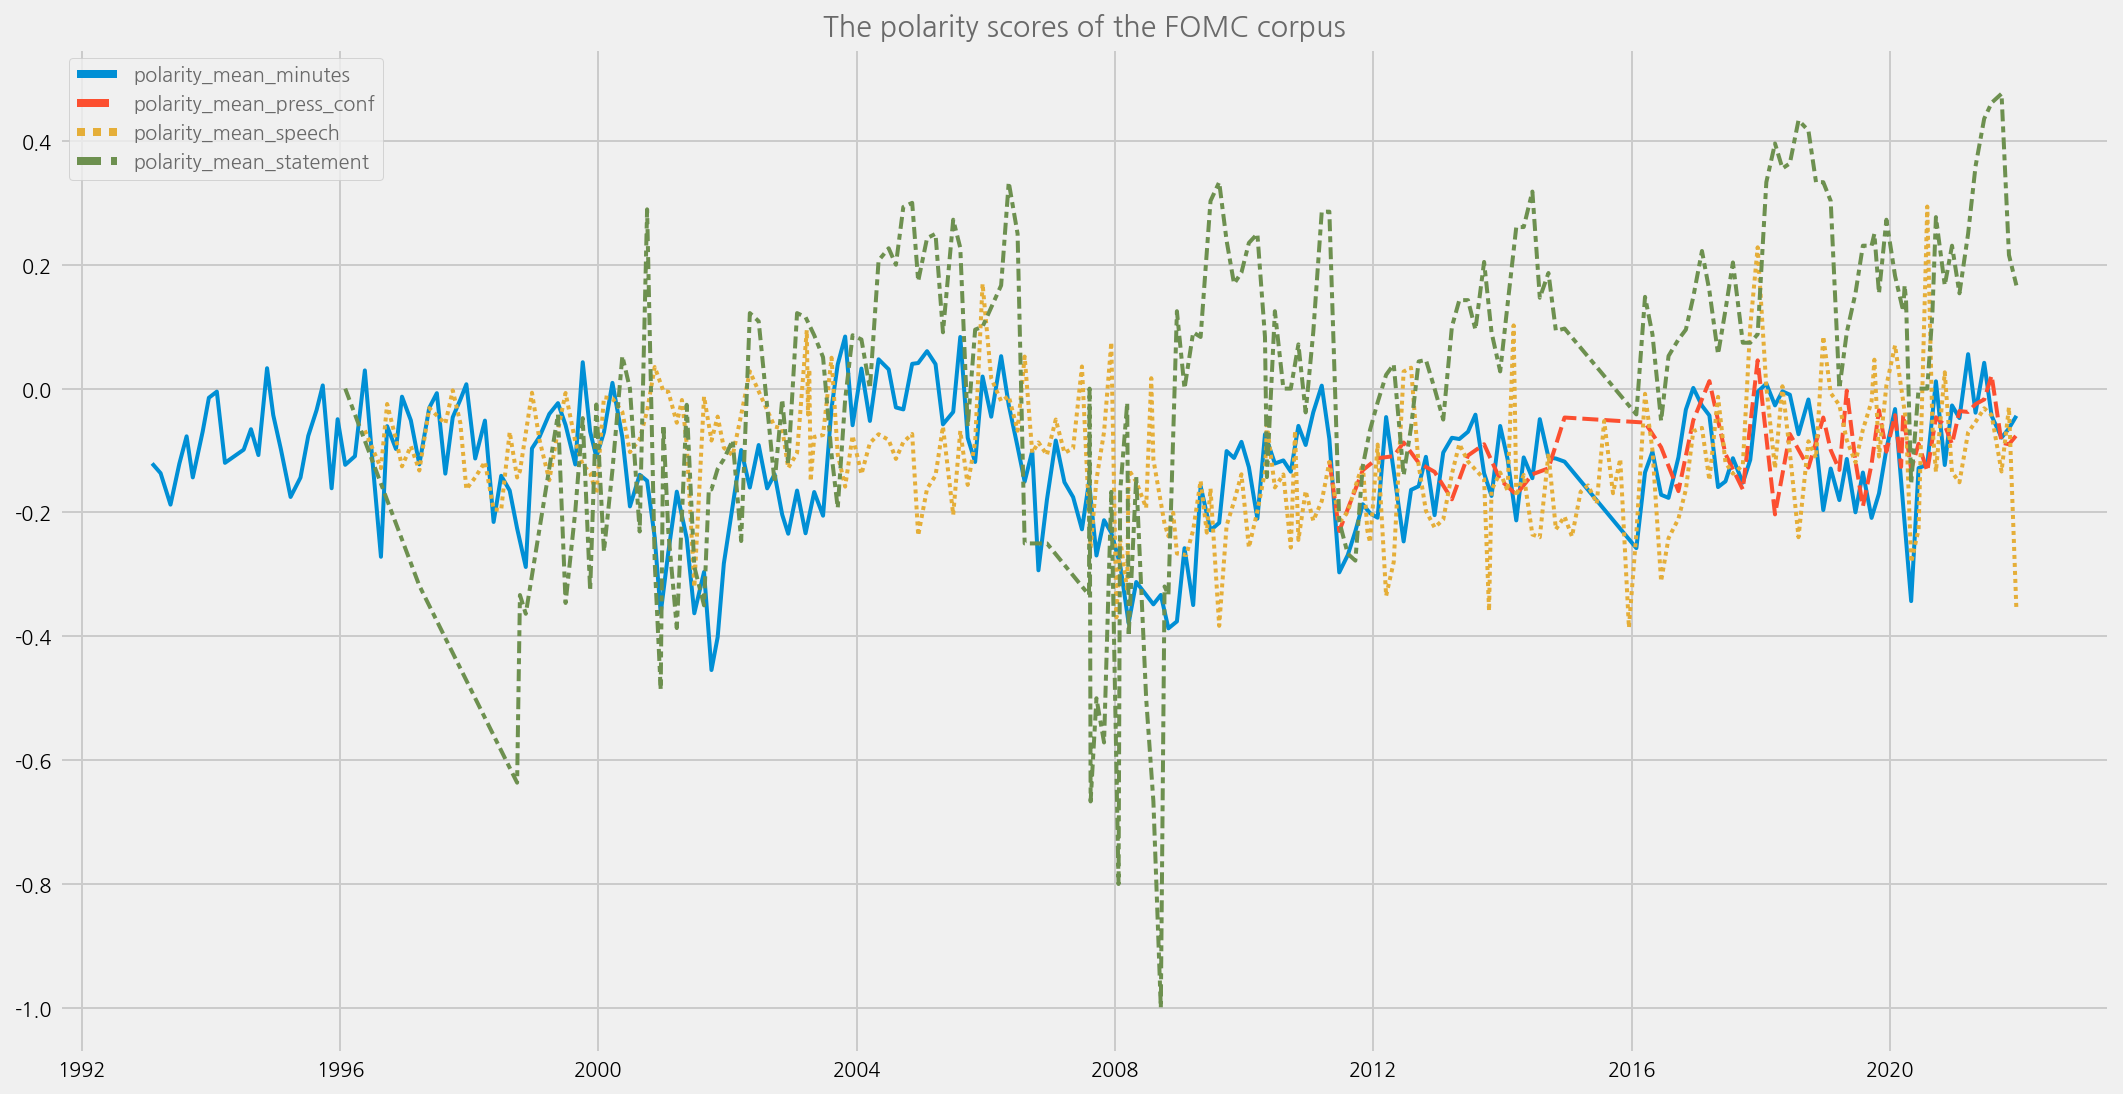

In [38]:
cfg = eKonf.compose('visualize/plot=lineplot')
cfg.plot.x = 'recent_meeting'
cfg.plot.y = ['polarity_mean_minutes', 'polarity_mean_press_conf', 'polarity_mean_speech', 'polarity_mean_statement']
cfg.figure.figsize = '(15, 8)'
cfg.ax.title = 'The polarity scores of the FOMC corpus'
eKonf.instantiate(cfg, data=data)

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


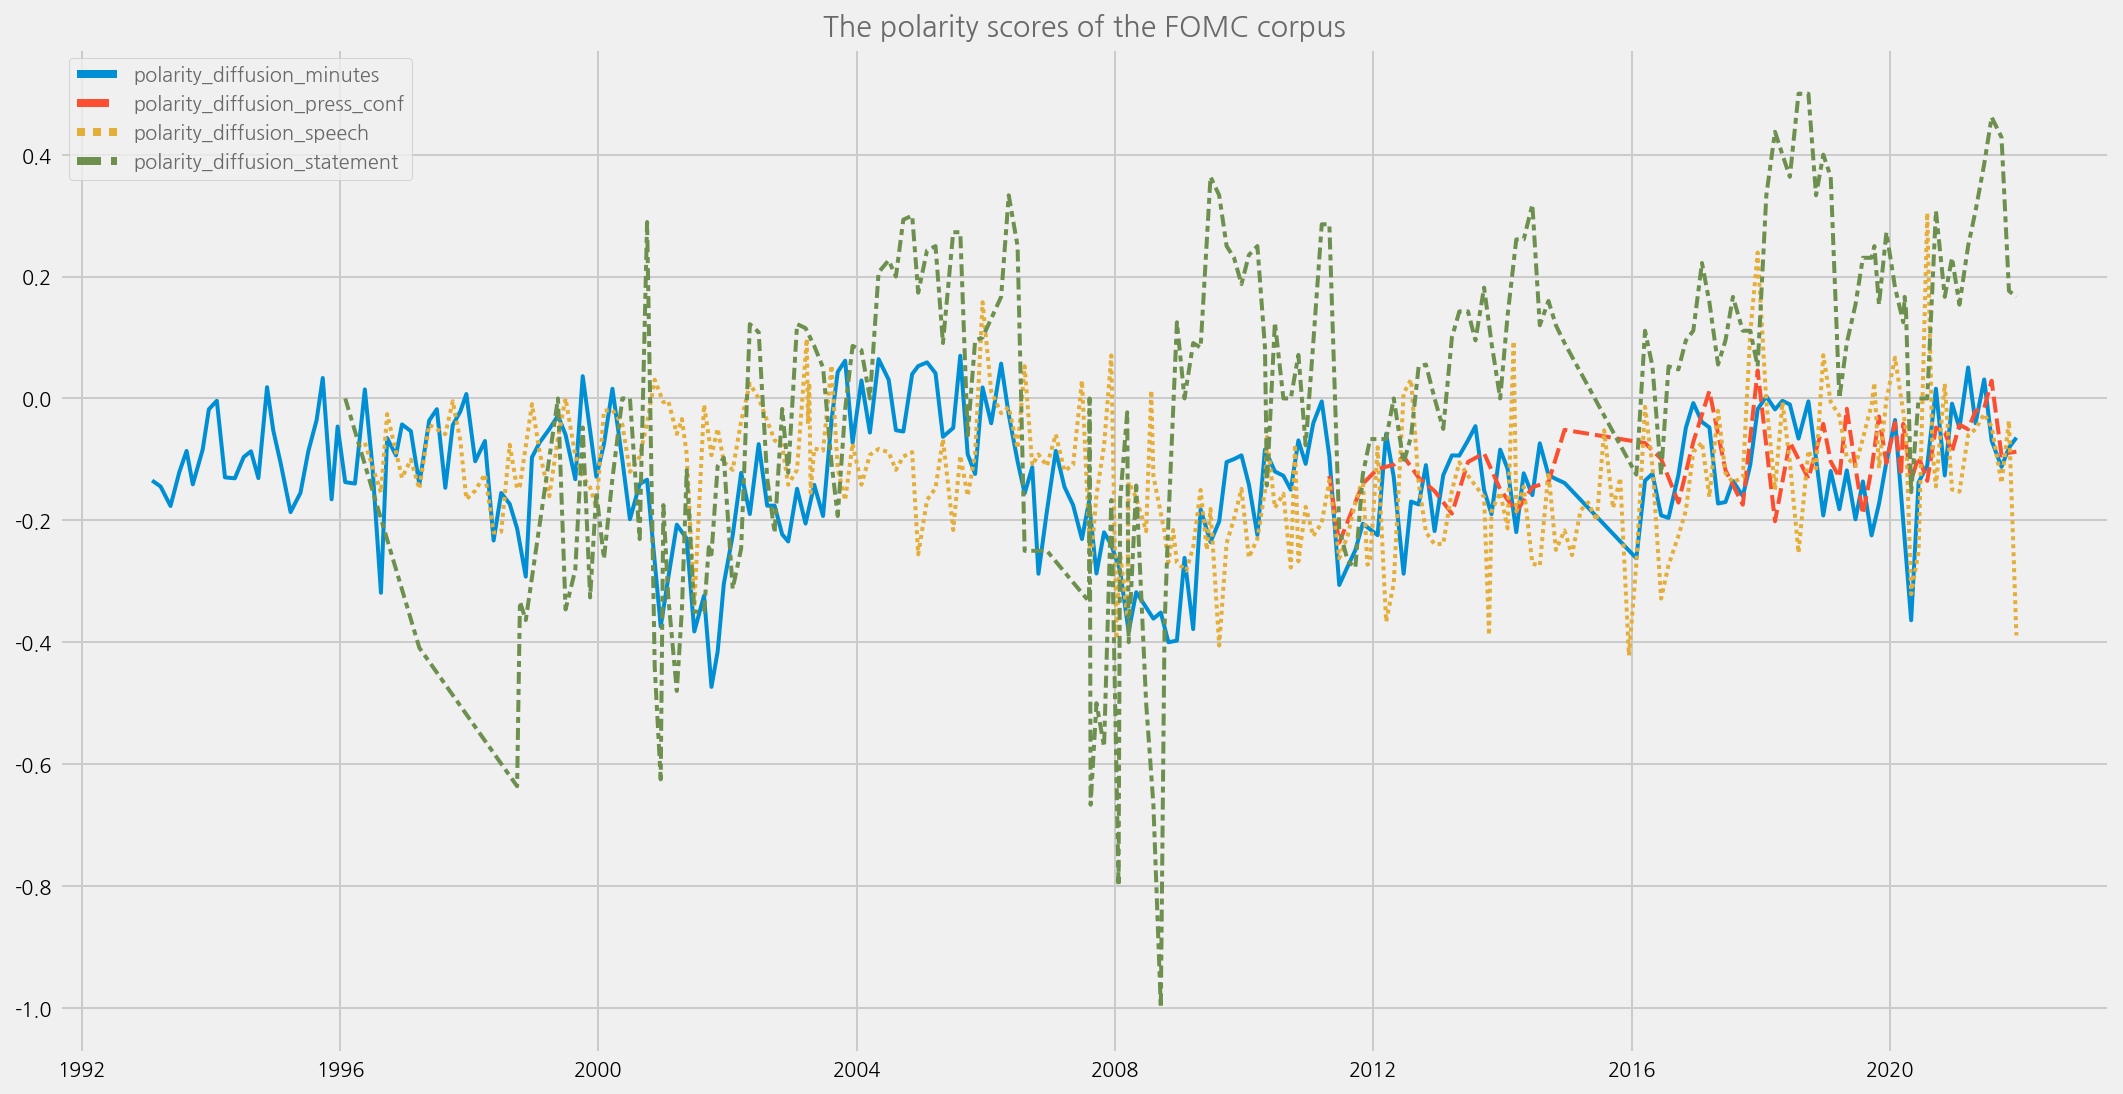

In [39]:
cfg = eKonf.compose('visualize/plot=lineplot')
cfg.plot.x = 'recent_meeting'
cfg.plot.y = ['polarity_diffusion_minutes', 'polarity_diffusion_press_conf', 'polarity_diffusion_speech', 'polarity_diffusion_statement']
cfg.figure.figsize = '(15, 8)'
cfg.ax.title = 'The polarity scores of the FOMC corpus'
eKonf.instantiate(cfg, data=data)

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


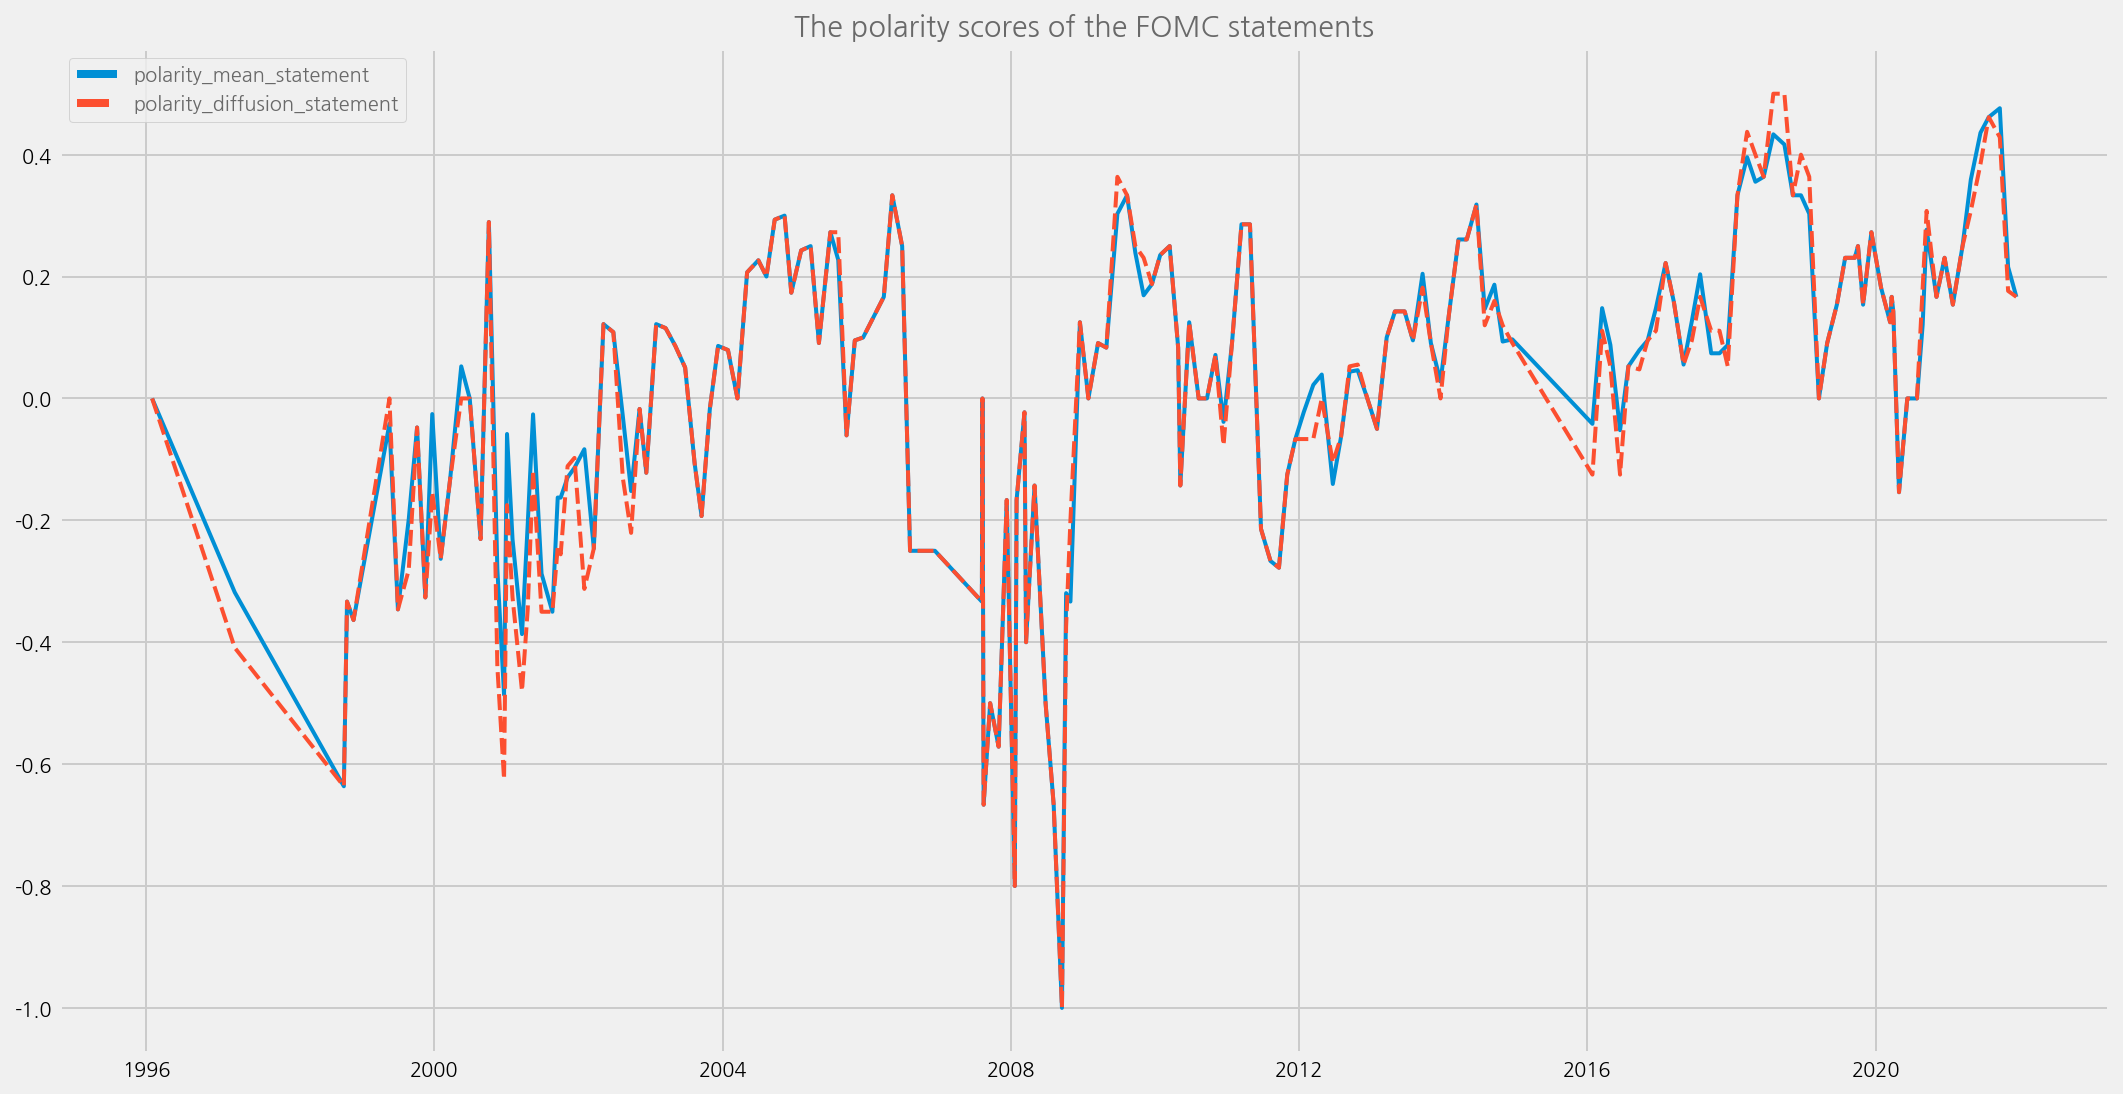

In [40]:
cfg = eKonf.compose('visualize/plot=lineplot')
cfg.plot.x = 'recent_meeting'
cfg.plot.y = ['polarity_mean_statement', 'polarity_diffusion_statement']
cfg.figure.figsize = '(15, 8)'
cfg.ax.title = 'The polarity scores of the FOMC statements'
eKonf.instantiate(cfg, data=data)

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'red', 'x': 'recent_meeting', 'y': 'num_tokens_sum_statement', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.plot:Creating secondary axis to axis[0]
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'green', 'x': 'recent_meeting', 'y': 'num_examples_statement', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort

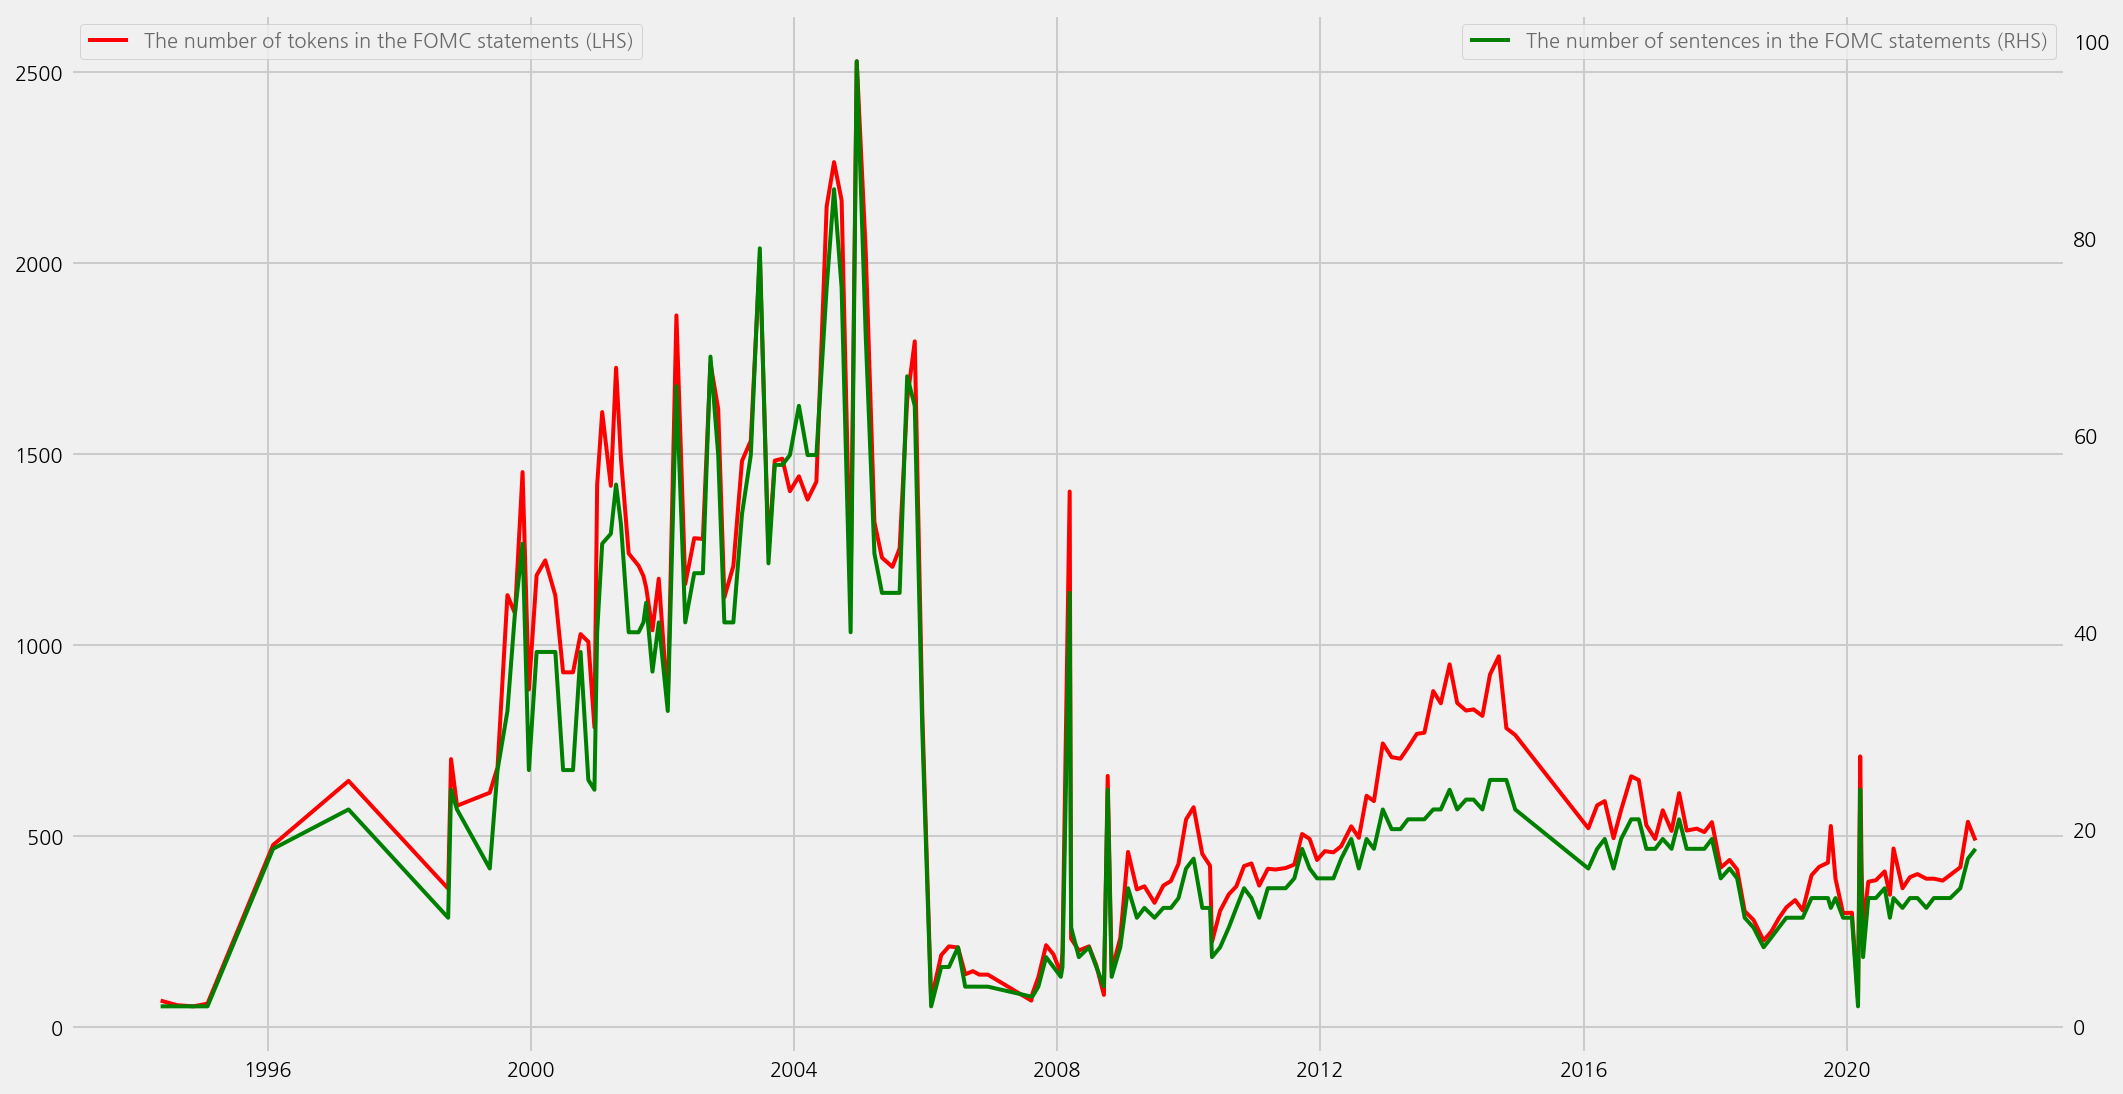

In [41]:
cfg = eKonf.compose('visualize/plot=lineplot')
cfg.figure.figsize = (15, 8)
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "num_tokens_sum_statement"
cfg.plots[0].rcParams = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "num_examples_statement"
cfg.plots[1].rcParams = dict(linewidth=1.5, color="green")
cfg.plots[1].secondary_y = True
cfg.ax.legend = dict(
    labels=[
        "The number of tokens in the FOMC statements (LHS)",
    ],
    loc=2,
)
ax2 = cfg.ax.copy()
ax2.grid = False
ax2.secondary_y = True
ax2.legend = dict(
    labels=["The number of sentences in the FOMC statements (RHS)"],
    loc=1,
)
cfg.axes.append(ax2)

eKonf.instantiate(cfg, data=data)

INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/StackPlot.png


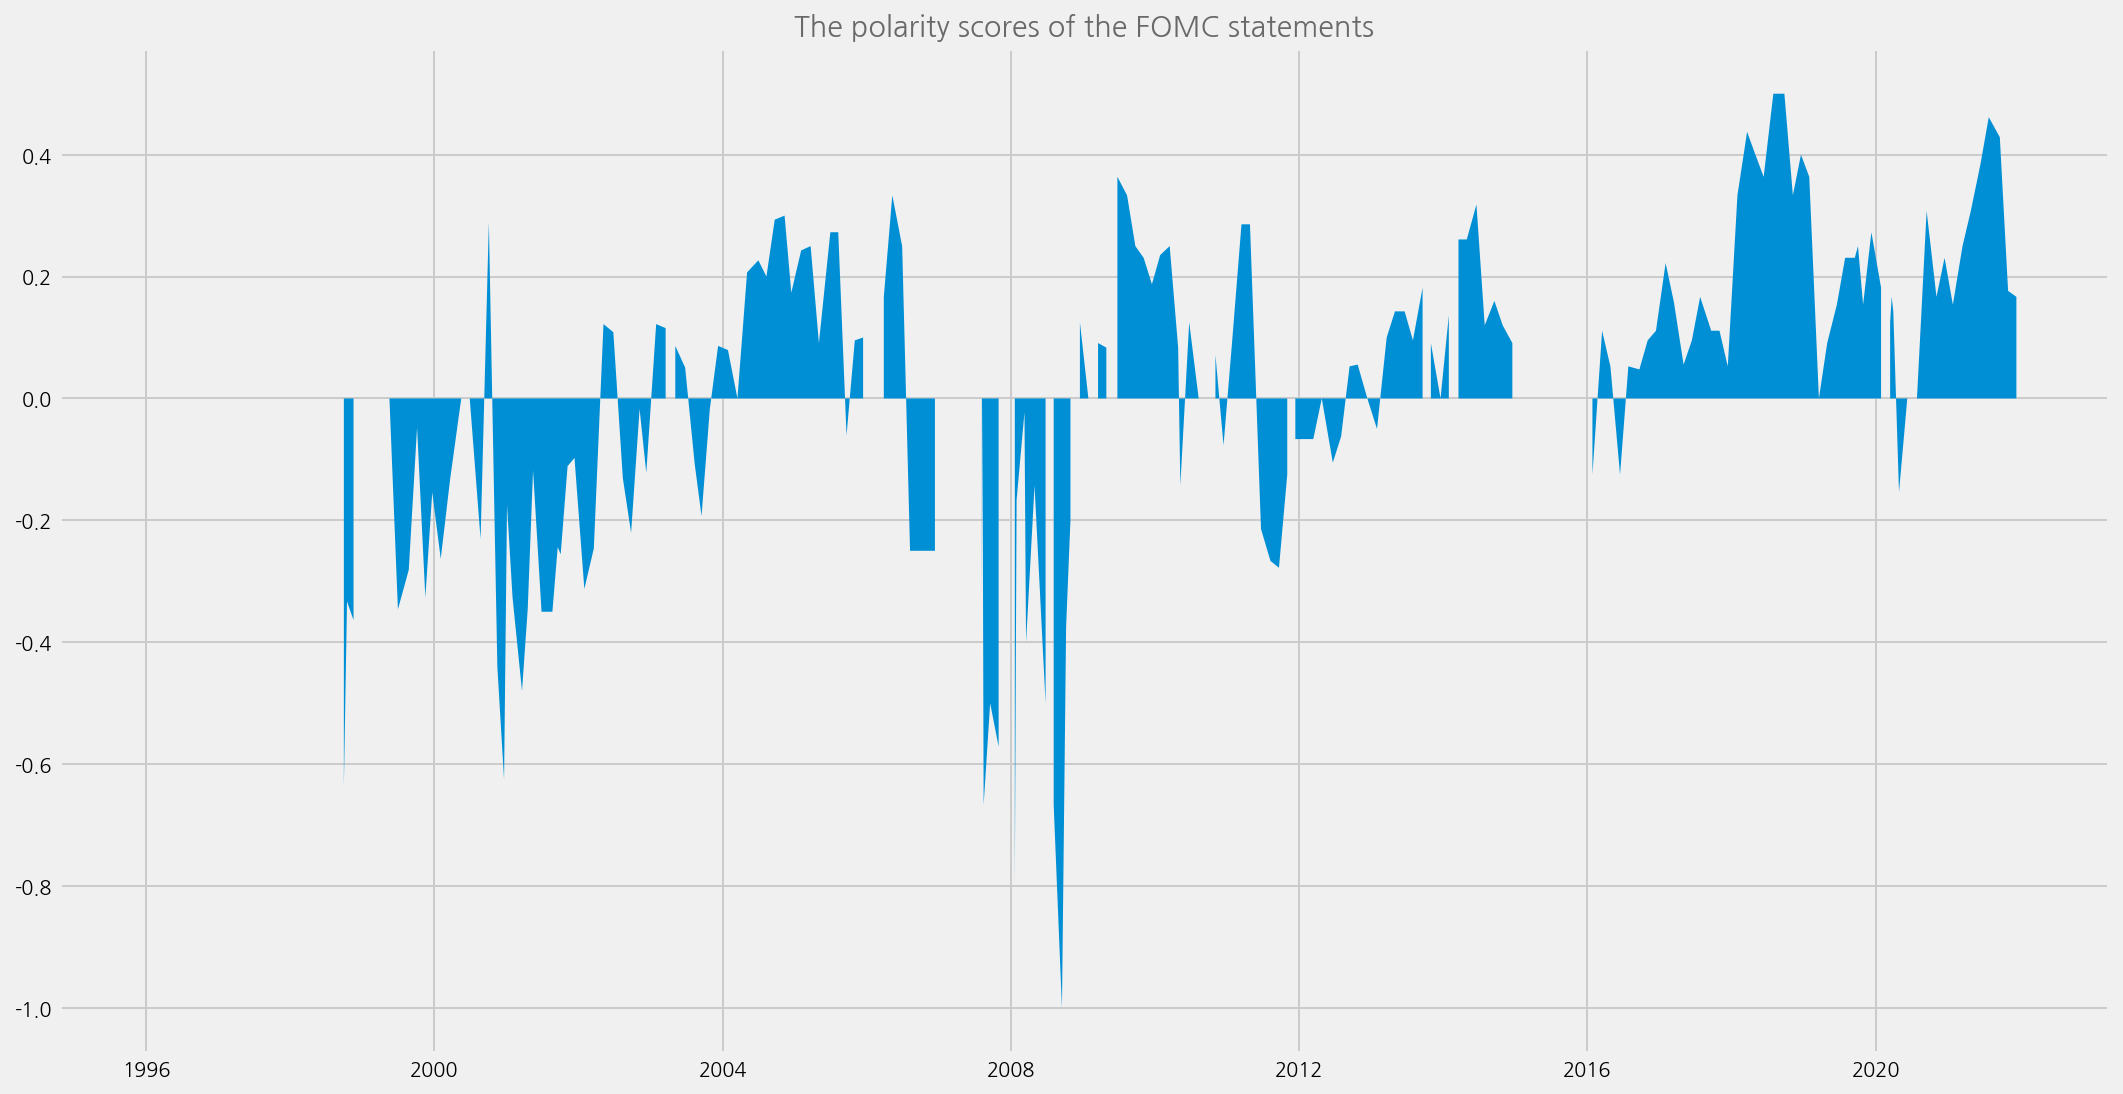

In [42]:
cfg = eKonf.compose('visualize/plot=stackplot')
cfg.plot.y = ['polarity_diffusion_statement']
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'The polarity scores of the FOMC statements'
cfg.ax.xtickmajorformatterfunc = "mdates.DateFormatter('%Y')"
eKonf.instantiate(cfg, data=data)


### Merge with fed rate data

INFO:ekorpkit.base:Applying pipe: functools.partial(<function eval_columns at 0x7f4f9d579700>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function eval_columns at 0x7f4f9d579700>)
INFO:ekorpkit.io.file:Saving dataframe to /workspace/.tmp/fred/DFEDTAR.parquet
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'date', 'y': 'DFEDTAR', 'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


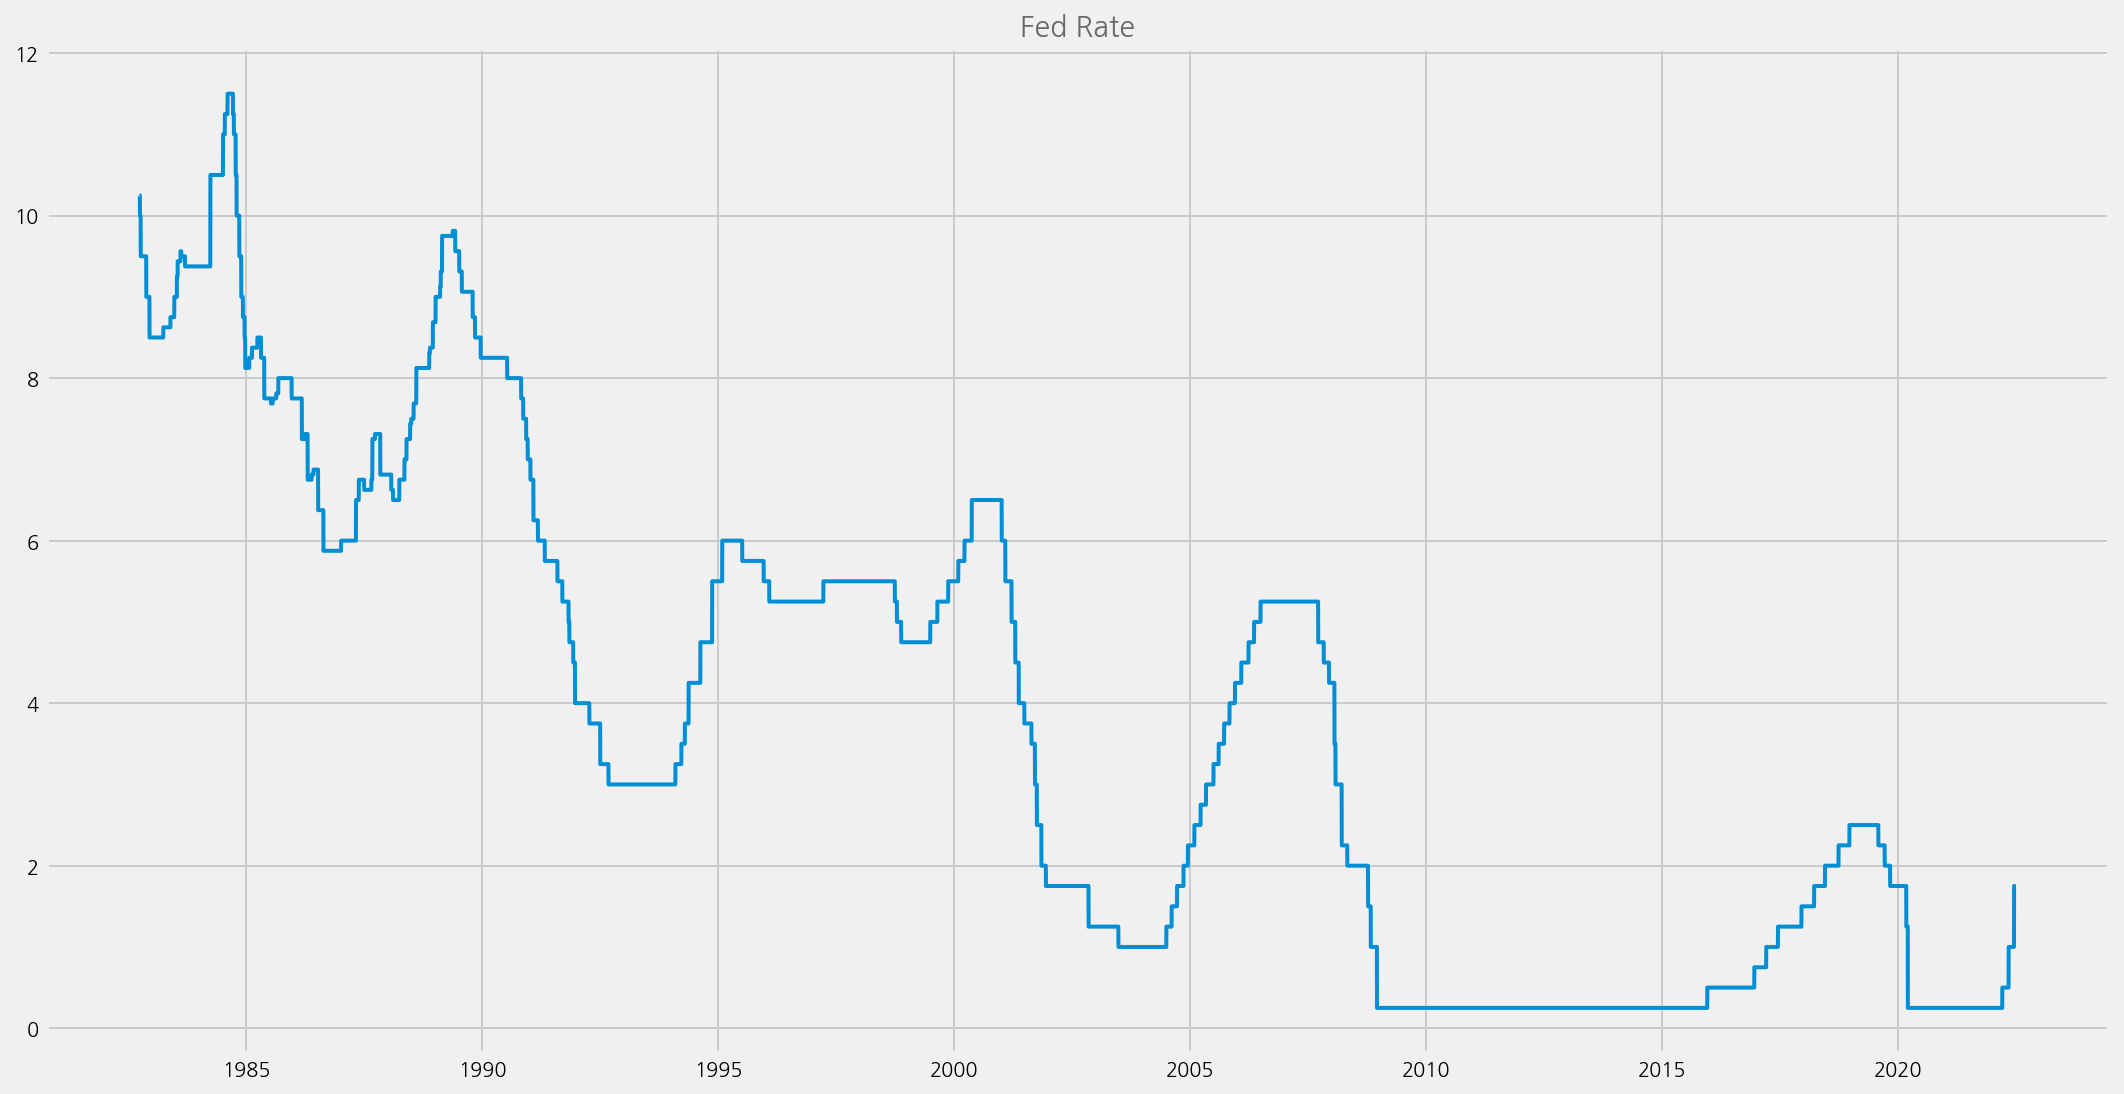

In [43]:
cfg = eKonf.compose("io/fetcher=quandl")
cfg.series_name = "DFEDTAR"
cfg.series_id = ["DFEDTAR", "DFEDTARU"]
cfg.force_download = True
quandl = eKonf.instantiate(cfg)

fedrates = quandl.data.copy()

cfg = eKonf.compose('visualize/plot=lineplot')
cfg.plot.x = 'date'
cfg.plot.y = 'DFEDTAR'
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'Fed Rate'
eKonf.instantiate(cfg, data=fedrates)

In [48]:
merged_data = data.merge(fedrates, left_index=True, right_index=True)
merged_data.index.name = 'timestamp'
merged_data.head()

,polarity_mean_beigebook,polarity_mean_meeting_script,polarity_mean_minutes,polarity_mean_press_conf,polarity_mean_speech,polarity_mean_statement,polarity_mean_testimony,polarity_diffusion_beigebook,polarity_diffusion_meeting_script,polarity_diffusion_minutes,...,num_tokens_sum_testimony,num_tokens_mean_beigebook,num_tokens_mean_meeting_script,num_tokens_mean_minutes,num_tokens_mean_press_conf,num_tokens_mean_speech,num_tokens_mean_statement,num_tokens_mean_testimony,DFEDTAR,series_id
timestamp,,,,,,,,,,,,,,,,,,,,,
1990-02-07,NaN,-0.087583,NaN,NaN,NaN,NaN,NaN,NaN,-0.095663,NaN,...,NaN,NaN,30.213010,NaN,NaN,NaN,NaN,NaN,8.25,DFEDTAR
1990-03-27,NaN,-0.171992,NaN,NaN,NaN,NaN,NaN,NaN,-0.179702,NaN,...,NaN,NaN,29.846369,NaN,NaN,NaN,NaN,NaN,8.25,DFEDTAR
1990-05-15,NaN,-0.116052,NaN,NaN,NaN,NaN,NaN,NaN,-0.125461,NaN,...,NaN,NaN,29.749077,NaN,NaN,NaN,NaN,NaN,8.25,DFEDTAR
1990-07-03,NaN,-0.114829,NaN,NaN,NaN,NaN,NaN,NaN,-0.117794,NaN,...,NaN,NaN,29.667920,NaN,NaN,NaN,NaN,NaN,8.25,DFEDTAR
1990-08-21,NaN,-0.209552,NaN,NaN,NaN,NaN,NaN,NaN,-0.219403,NaN,...,NaN,NaN,31.032836,NaN,NaN,NaN,NaN,NaN,8.00,DFEDTAR


### Plot the results and compare to the economical uncertainty / systemic risk periods

In [49]:
cfg = eKonf.compose("io/fetcher/fomc")
cfg.output_dir = "../data/fomc"
fomc = eKonf.instantiate(cfg)

INFO:ekorpkit.io.fetch.fomc.base:Initializing fomc_base


In [50]:
recessions = fomc.recessions.to_dict(orient="records")

span_args = eKonf.compose("visualize/plot/ax/axvspan")
annot_args = eKonf.compose("visualize/plot/ax/annotation")
span_args.color = "crimson"
span_args.alpha = 0.4

spans = []
annotations = []
for span in recessions:
    annotation = span["name"]
    start = span["from_date"]
    end = span["to_date"]
    span = span_args.copy()
    span.xmin, span.xmax = eKonf.to_dateparm(start), eKonf.to_dateparm(end)

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y
    spans.append(span)
    annotations.append(annot)


INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'timestamp', 'y': 'polarity_ma', 'linewidth': 2.5, 'palette': 'r', 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'timestamp', 'y': 'polarity_diffusion_statement', 'linewidth': 1.5, 'palette': 'g', 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:

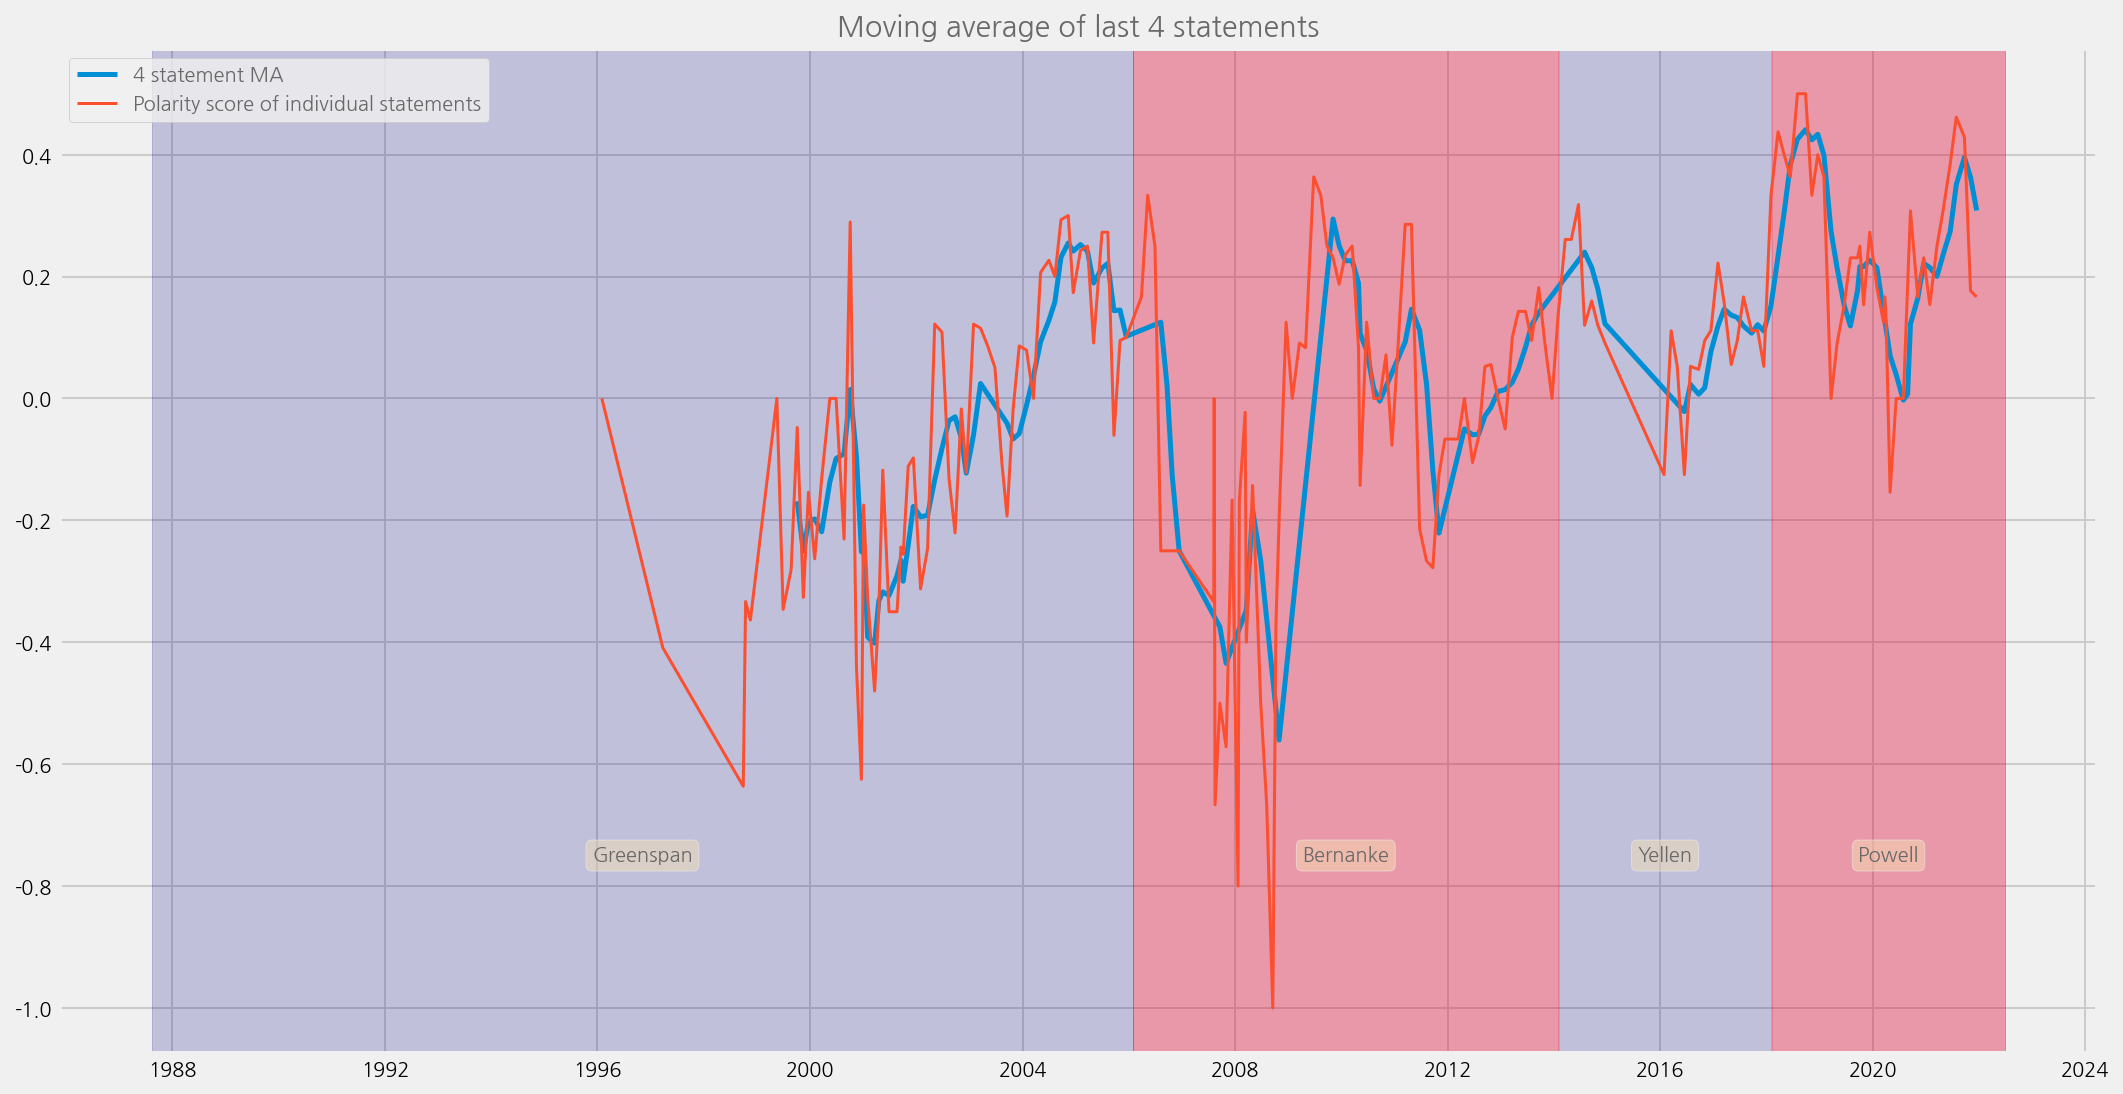

In [62]:
window = 4
merged_data["polarity_ma"] = merged_data['polarity_diffusion_statement'].rolling(window).mean()

cfg = eKonf.compose("visualize/plot=lineplot")
cfg.figure.figsize = (15, 8)
cfg.plot.x = "timestamp"
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].linewidth = 2.5
cfg.plots[0].palette = "r"
cfg.plots[1].y = "polarity_diffusion_statement"
cfg.plots[1].linewidth = 1.5
cfg.plots[1].palette = "g"
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend.labels = [
    f"{window} statement MA",
    "Polarity score of individual statements",
]
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations
eKonf.instantiate(cfg, data=merged_data)

In [59]:
from datetime import datetime

chair = fomc.chairpersons
chair = chair[chair.to_date.dt.year >= start_year]
annot_args = eKonf.compose("visualize/plot/ax/annotation")

spans = []
annotations = []
for row in chair.iterrows():
    row_num = row[0]
    start = row[1]["from_date"]
#     if start.year < 2000:
#         start = datetime(2000, 1, 1)
    end = row[1]["to_date"]
    annotation = row[1]["last_name"]
    color = "crimson" if row_num % 2 == 0 else "darkblue"
    alpha = 0.4 if row_num % 2 == 0 else 0.2
    span = {
        "xmin": eKonf.to_dateparm(start),
        "xmax": eKonf.to_dateparm(end),
        "alpha": alpha,
        "color": color,
    }

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y

    spans.append(span)
    annotations.append(annot)


INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'red', 'x': 'timestamp', 'y': 'polarity_ma', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'green', 'x': 'timestamp', 'y': 'polarity_diffusion_statement', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': Non

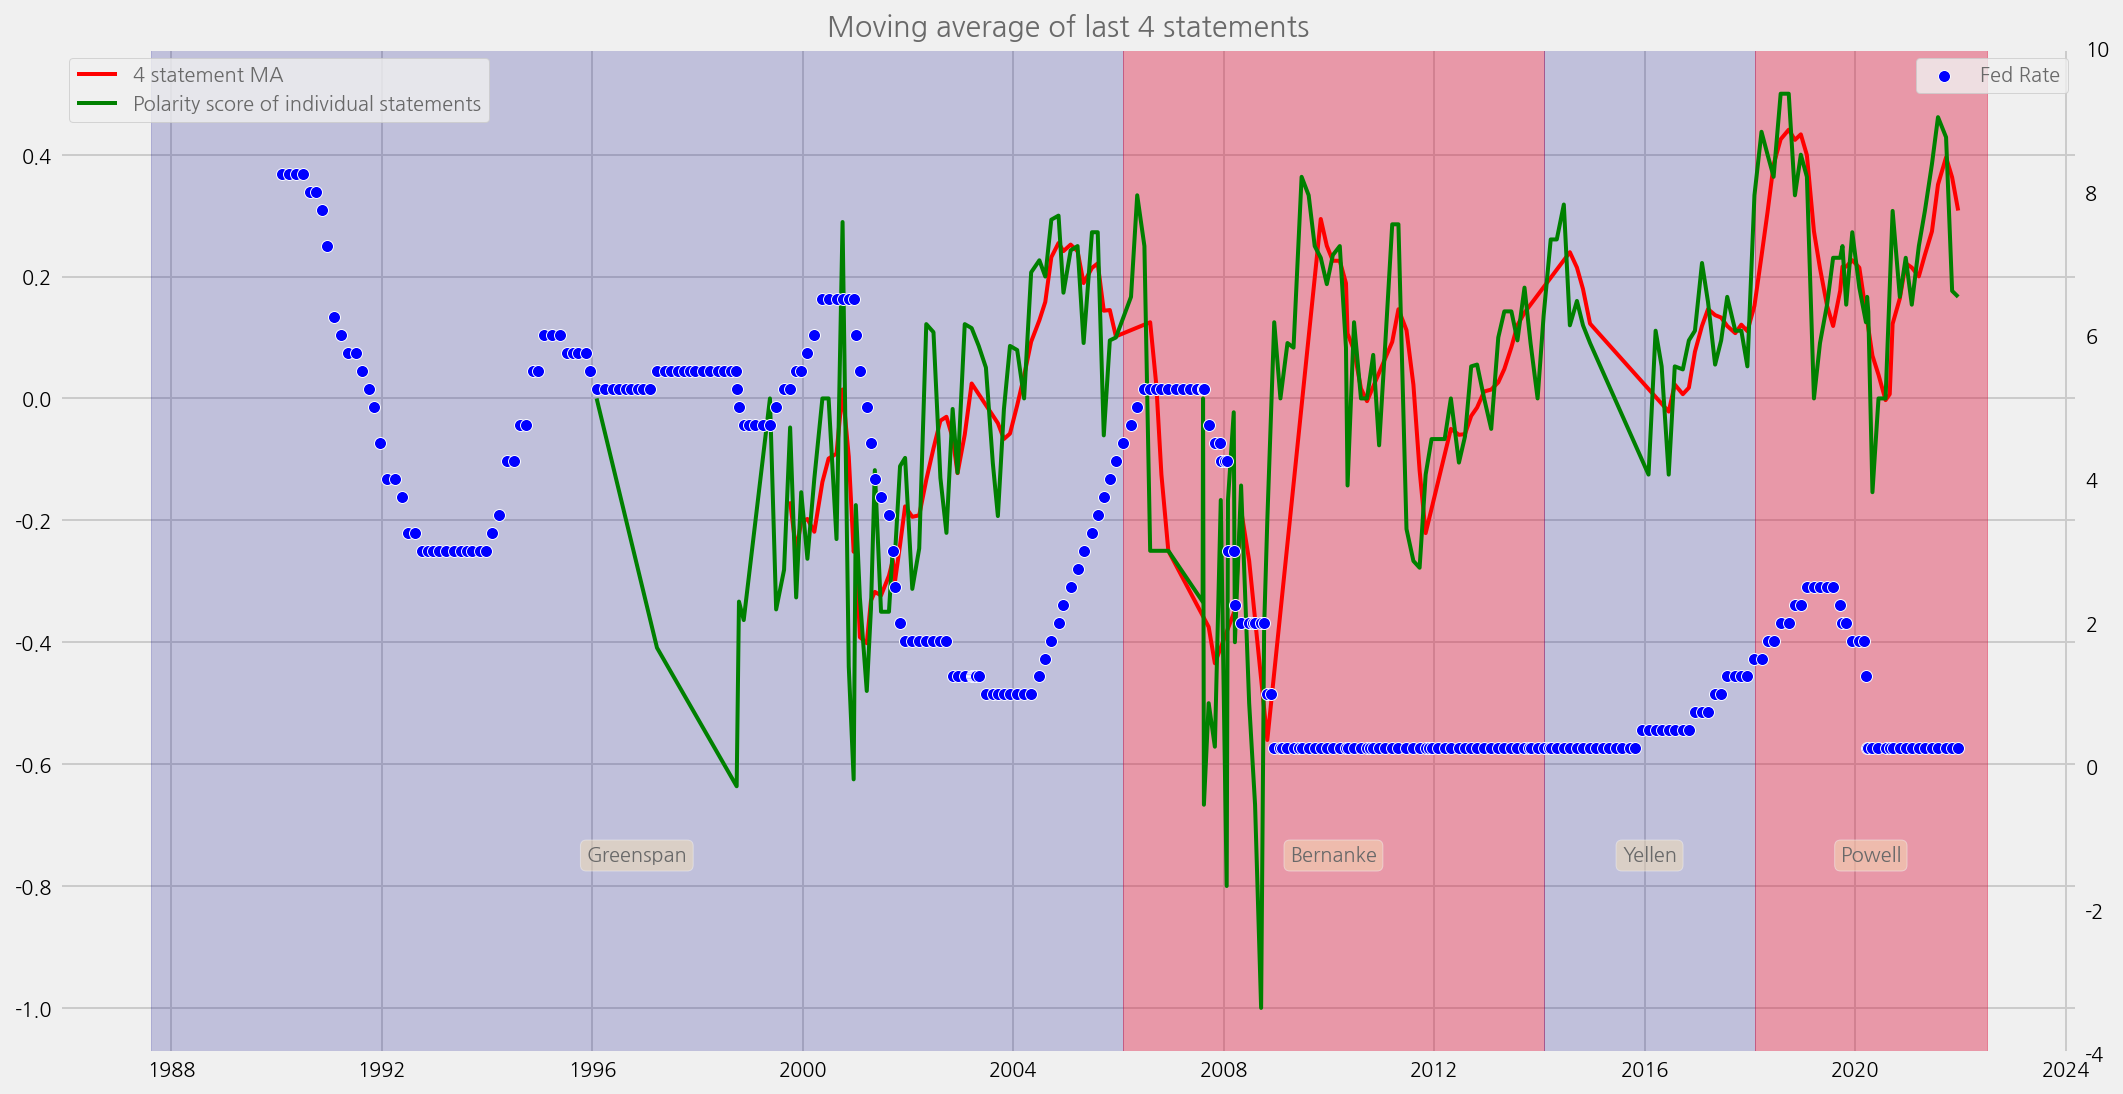

In [60]:
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.plot.x = "timestamp"
ax2 = cfg.ax.copy()

cfg.figure.figsize = (15, 8)
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].rcParams = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "polarity_diffusion_statement"
cfg.plots[1].rcParams = dict(linewidth=1.5, color="green")
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend = dict(
    labels=[
        f"{window} statement MA",
        "Polarity score of individual statements",
    ],
    loc=2,
)
scatter_cfg = eKonf.compose("visualize/plot/scatterplot")
scatter_cfg.y = "DFEDTAR"
scatter_cfg.secondary_y = True
scatter_cfg.rcParams = dict(color="blue", alpha=0.8)
cfg.plots.append(scatter_cfg)

ax2.grid = False
ax2.secondary_y = True
ax2.ylim = "(-4, 10)"
ax2.legend = dict(
    labels=["Fed Rate"],
    loc=1,
)
cfg.axes.append(ax2)
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations

eKonf.instantiate(cfg, data=merged_data)
